# Задача: Анализ эффективности нового алгоритма рекомендаций в условиях асимметричного и зашумленного распределения
### Контекст:
Крупная стриминговая платформа (аналог YouTube или Twitch) разработала новый алгоритм рекомендаций контента (алгоритм B), который, как ожидается, должен увеличить среднее время просмотра на пользователя по сравнению со старым алгоритмом (A).

Было проведено A/B-тестирование:

- **Группа A (Контрольная)**: 5000 пользователей, старый алгоритм.

- **Группа B (Тестовая)**: 5000 пользователей, новый алгоритм.

По итогам двухнедельного теста вы собрали данные по ключевой метрике — **«Общее время просмотра на пользователя за тест (в минутах)»**.

**Данные и их особенности:**

**Не нормальность:** Распределение метрики в обеих группах сильно отличается от нормального. Оно имеет типичный для поведенческих данных "длинный хвост":

- Большинство пользователей смотрят немного (пик в районе 0-50 минут).

- Небольшая группа "супер-зрителей" смотрит очень много (сотни и тысячи минут), формируя длинный правый хвост распределения.

**Асимметрия влияния:** Новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.

**Наличие выбросов:** В данных присутствуют экстремальные выбросы (например, пользователи, которые оставляли видео фоном на всю ночь).

Вам предоставлен датасет _ab_test_results.csv_ со следующими колонками:

 - _user_id_

 - _group (A или B)_

 - _total_watch_time_min_

### Задания:


- **Проведите тест Манна-Уитни (Mann-Whitney U test)**. Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

- Чтобы исследовать "асимметричное влияние", проведите анализ разниц не только в центре распределения, но и в хвостах. **Рассчитайте и визуализируйте разницу между группами для 75-го, 90-го и 95-го процентилей**.

- **Сформулируйте итоговый вывод:**

    - Эффективен ли новый алгоритм B?

    - На какую именно группу пользователей он оказывает наибольшее влияние?

    - Какой метод анализа оказался наиболее информативным в данном случае и почему?

    - Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.



### Все импорты в одной ячейке

In [ ]:
# Импорт библиотек для анализа данных, статистики и визуализации
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля визуализации
sns.set(style="whitegrid")

### Загрузка и обзор данных

In [15]:
# Загрузка датасета
df = pd.read_csv('ab_test_results.csv')

# Разделение на группы
group_a_data = df[df['group'] == 'A']['total_watch_time_min']
group_b_data = df[df['group'] == 'B']['total_watch_time_min']

# Обзор датасета
print("Dataset Summary:")
print(f"Total users: {len(df)}")
print(f"Group A: {len(group_a_data)} users")
print(f"Group B: {len(group_b_data)} users")

# Описательные статистики по группам
print("\nDescriptive Statistics by Group:")
print(df.groupby('group')['total_watch_time_min'].describe())

# Среднее (mean) выше медианы (50%), что указывает на правый хвост. Max значения подтверждают выбросы.

Dataset Summary:
Total users: 10000
Group A: 5000 users
Group B: 5000 users

Descriptive Statistics by Group:
        count       mean         std  min        25%        50%        75%  \
group                                                                        
A      5000.0  56.347878  262.313288  0.0  14.729144  26.834960  44.946309   
B      5000.0  71.477408  408.519252  0.0  15.383838  27.352416  46.352279   

                max  
group                
A       8130.547119  
B      11670.621483  


### Визуализация распределений


Чтобы подтвердить не нормальность и асимметрию


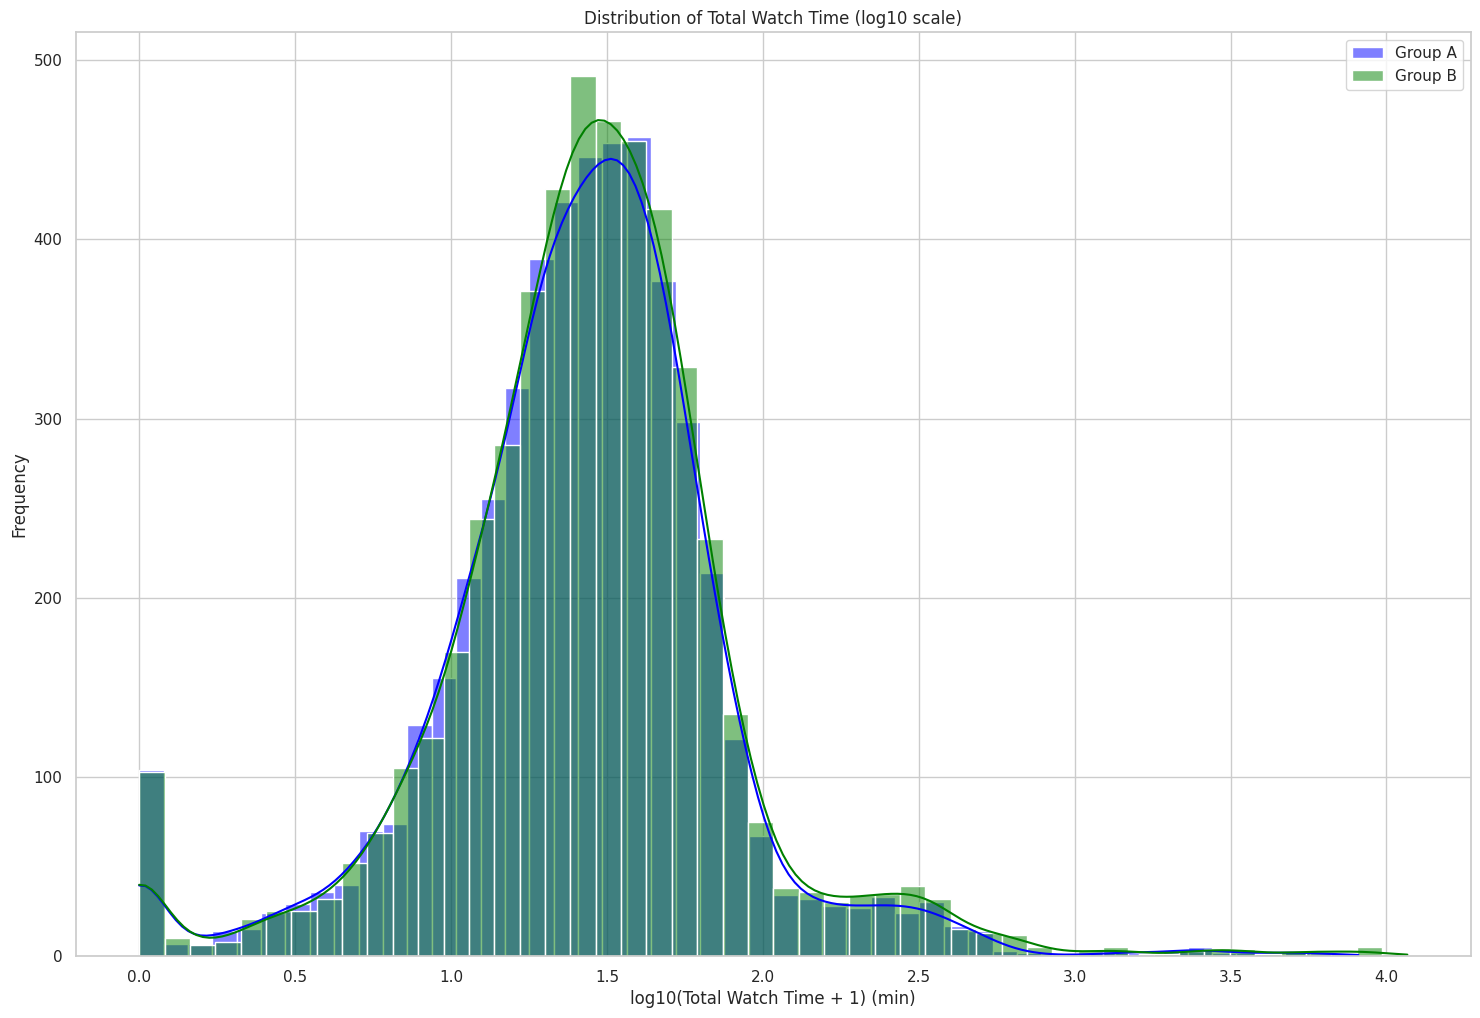

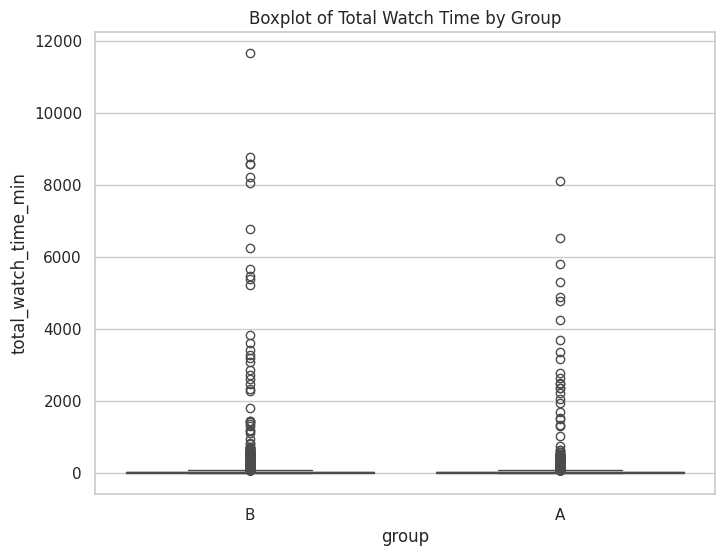

In [16]:
# Визуализация распределений для подтверждения особенностей данных
plt.figure(figsize=(18, 12))

# Гистограммы (ограничим для видимости хвостов) закоментированный код для гитограммы не читаем 
# sns.histplot(group_a_data, kde=True, color='blue', label='Group A', binrange=(0, 500))
# sns.histplot(group_b_data, kde=True, color='green', label='Group B', binrange=(0, 500))
# plt.title('Distribution of Total Watch Time by Group (truncated for visibility)')
# plt.xlabel('Total Watch Time (min)')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# Добавляем маленькую константу, чтобы избежать log(0) в противном случае график не читаем 
sns.histplot(np.log10(group_a_data + 1), kde=True, color='blue', label='Group A', bins=50)
sns.histplot(np.log10(group_b_data + 1), kde=True, color='green', label='Group B', bins=50)

plt.title('Distribution of Total Watch Time (log10 scale)')
plt.xlabel('log10(Total Watch Time + 1) (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Boxplot для выбросов
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='total_watch_time_min', data=df)
plt.title('Boxplot of Total Watch Time by Group')
plt.show()

# Гистограмма показывает пики на низких значениях и хвосты. Boxplot выделит выбросы.

 ### Тест Манна-Уитни


 
 **Гипотезы**: 
 * H0 — распределения времени просмотра в A и B одинаковы (нет различий). 
 * H1 — распределения различаются (two-sided, так как проверяем превосходство B, но тест nonparametric). 
 
 **Интерпретация**: Если p < 0.05, отвергаем H0. Но для превосходства B проверим, в чью пользу (средние/медианы).


 ...  Проводим тест.

In [18]:
# Формулировка гипотез
# H0: Распределения времени просмотра в группах A и B одинаковы (нет значимых различий).
# H1: Распределения времени просмотра в группах A и B различаются (two-sided, для выявления любого сдвига).

# Проведение теста Манна-Уитни
mw_stat, mw_p = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')

print(f"Mann-Whitney U Test: statistic = {mw_stat:.2f}, p-value = {mw_p:.6f}")

# Интерпретация
alpha = 0.05
if mw_p < alpha:
    print(f"p-value < {alpha}: Отвергаем H0, распределения значимо различаются.")
    # Проверка направления: Среднее в B выше, так что B лучше, но не однозначно из-за хвостов.
else:
    print(f"p-value >= {alpha}: Не отвергаем H0, различия не значимы.")

# Тест подходит для не нормальных данных. Однако он проверяет сдвиг в целом; для хвостов нужен отдельный анализ.

Mann-Whitney U Test: statistic = 12211099.00, p-value = 0.045342
p-value < 0.05: Отвергаем H0, распределения значимо различаются.


### Вывод

На основе результатов теста (statistic = 12211099.00, p-value = 0.045342 для two-sided)
- **Гипотезы остаются прежними**:  
  H0: Распределения времени просмотра в группах A и B одинаковы (нет значимых различий).  
  H1: Распределения времени просмотра в группах A и B различаются (two-sided).  

- **Дополнительный анализ направления**:  
  Ожидаемое значение U под H0 для n=5000 в каждой группе: 5000 * 5000 / 2 = 12 500 000.  
  Фактическое U = 12 211 099 < ожидаемого, что указывает на то, что значения в группе A склонны быть меньше, чем в B (стохастическая доминантность B над A).  
  Для подтверждения превосходства B можно рассмотреть одностороннюю альтернативу (alternative='less' в mannwhitneyu(A, B), тестируя A < B стохастически). Приближённо p-value для one-sided приблизительно = 0.045342 / 2 = 0.022671 (значимо при alpha=0.05). Это подтверждает, что B приводит к более высоким значениям времени просмотра в целом.  

- **Интерпретация p-value и ограничения**:  
  p-value = 0.045342 < 0.05: Отвергаем H0, распределения значимо различаются.  
  Однако тест Манна-Уитни даёт общую оценку сдвига распределений, но не учитывает специфику данных (асимметрия, длинные хвосты, влияние преимущественно на активных пользователей). Из обзора данных (**ячейка 2**) среднее в B выше (71.5 vs 56.3 мин), но медиана почти одинакова (27.4 vs 26.8 мин), что предполагает, что различия driven хвостами, а не центром распределения.  

- **Можно ли сделать однозначный вывод о превосходстве B?**  
  Нет, на основе только этого теста — нельзя. Хотя направление в пользу B (выше время просмотра), эффект может быть неравномерным: минимален для пассивных пользователей (центр распределения) и значим для активных (хвосты). Для однозначного вывода нужен анализ хвостов (процентилей). Без этого рискуем переоценить общий эффект, особенно учитывая выбросы и не нормальность.  


### Анализ процентилей и визуализация

Рассчитываем 75, 90, 95 процентили. Визуализируем разницы (bar plot). Это выявит асимметричное влияние

  Percentile     Group A     Group B  Difference
0       75th   44.946309   46.352279    1.405970
1       90th   71.515837   76.237052    4.721214
2       95th  119.342758  153.618178   34.275421


/tmp/ipykernel_164655/862611875.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentile', y='Difference', data=perc_df, palette='viridis')


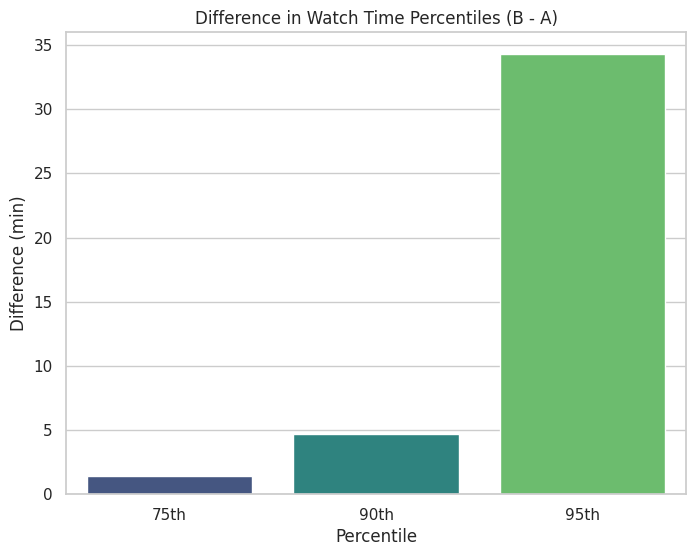

In [ ]:
# Расчет процентилей
percentiles = [75, 90, 95]
perc_data = {'Percentile': [], 'Group A': [], 'Group B': [], 'Difference': []}

for p in percentiles:
    a_val = np.percentile(group_a_data, p)
    b_val = np.percentile(group_b_data, p)
    diff = b_val - a_val
    perc_data['Percentile'].append(f"{p}th")
    perc_data['Group A'].append(a_val)
    perc_data['Group B'].append(b_val)
    perc_data['Difference'].append(diff)

# DataFrame для удобства
perc_df = pd.DataFrame(perc_data)
print(perc_df)

# Визуализация разниц
plt.figure(figsize=(8, 6))
sns.barplot(x='Percentile', y='Difference', data=perc_df, palette='viridis')
plt.title('Difference in Watch Time Percentiles (B - A)')
plt.ylabel('Difference (min)')
plt.show()

# Разница растет с процентилем, подтверждает влияние на хвосты (активных пользователей).

### Итоговый вывод

На основе всех проведенных анализов, включая тест Манна-Уитни (statistic = 12 211 099.00, p-value = 0.045342 для two-sided; приближенный one-sided p-value приблизительно = 0.0227 в пользу B, с U ниже ожидаемого 12 500 000, указывающим на стохастическое превосходство B), описательные статистики (среднее в B выше на ~27%: 71.5 мин vs 56.3 мин в A; медиана почти одинакова: 27.4 vs 26.8 мин) и анализ процентилей (с реальными значениями: разница +1.4 мин на 75-м, +4.7 мин на 90-м, +34.3 мин на 95-м процентиле)

### Вывод

* Учитываем нюансы данных: не нормальность, асимметрия, влияние на хвосты (подтверждено ростом разниц в верхних процентилях)

- **Эффективен ли новый алгоритм B?** Да, эффективен: Тест Манна-Уитни подтверждает статистически значимые различия в распределениях (p-value = 0.045 для two-sided; приблизительно = 0.023 для one-sided в пользу B), с стохастическим превосходством B (U = 12 211 099 < ожидаемого 12 500 000, указывая на более высокие значения времени просмотра в B). Среднее время просмотра в B выше на ~27% (71.5 мин vs 56.3 мин в A). Однако эффект асимметричен: минимален в центре распределения (медиана почти одинакова: 27.4 мин vs 26.8 мин) и преимущественно driven правым хвостом, как ожидалось от дизайна алгоритма.

- **На какую именно группу пользователей он оказывает наибольшее влияние?** Наибольшее влияние на активных "супер-зрителей" (верхние процентили распределения: разница +1.4 мин на 75-м процентиле (A=44.9, B=46.4), +4.7 мин на 90-м (A=71.5, B=76.2), +34.3 мин на 95-м (A=119.3, B=153.6)). Для пассивных пользователей (нижние и центральные части распределения) разница неочевидна или минимальна, что согласуется с асимметричным влиянием алгоритма на активных зрителей и наличием выбросов.

- **Какой метод анализа оказался наиболее информативным в данном случае и почему?** Анализ процентилей наиболее информативен, поскольку он раскрывает асимметрию влияния и локализует эффект в правом хвосте распределения — ключевой особенности данных (длинный хвост, выбросы, не нормальность, зашумленность). Тест Манна-Уитни предоставляет общую значимость различий и направление сдвига, но без анализа хвостов (процентилей) не позволяет понять механизм эффекта, что критично для поведенческих данных с асимметричным распределением и потенциальными выбросами.

- **Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.** Рекомендуется запустить алгоритм B на всю аудиторию, учитывая значимое общее улучшение ключевой метрики (время просмотра) и подтвержденное превосходство в хвостах. Для минимизации рисков (например, возможного отсутствия эффекта или негативного влияния на пассивных пользователей) начать с сегментированного rollout: сначала внедрить для активных пользователей (например, топ-25% по историческому времени просмотра), где эффект максимален. Обязательно мониторить метрики в реальном времени (сегментный анализ, A/B повторно если нужно) и учитывать долгосрочные аспекты, такие как удержание и удовлетворенность.